### Install Dependency

In [67]:
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install scipy
# %pip install statsmodels

### Imports

In [100]:
#Python 3.10.8 statsmodels 0.14.0.dev598+g46116c493
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from datetime import datetime
import warnings
from colorama import Fore
warnings.filterwarnings("ignore")
register_matplotlib_converters()

### Retrive data from .csv file

In [69]:
#Read data
csv_file = 'CPIUSSA.csv'
df = pd.read_csv('DataSet\\'+csv_file)
df.dropna(inplace=True)
df.head()

,DATE,CPILFESL
0,1957-01-01,28.5
1,1957-02-01,28.6
2,1957-03-01,28.7
3,1957-04-01,28.8
4,1957-05-01,28.8


### Require Dataframe with format (datetime , Time Series data) only

In [70]:
#Data cleaning
# df['Date'] = df['Year']
# for index in df.index:
#     if (df['Quarter'][index] == 'Q1'):
#         df['Date'][index] = str(df['Year'][index]) + '-03-01'
#     elif (df['Quarter'][index] == 'Q2'):
#         df['Date'][index] = str(df['Year'][index]) + '-06-01'
#     elif (df['Quarter'][index] == 'Q3'):
#         df['Date'][index] = str(df['Year'][index]) + '-09-01'
#     elif (df['Quarter'][index] == 'Q4'):
#         df['Date'][index] = str(df['Year'][index]) + '-12-01'

# convert floating point to int then to str
# df['Date'] = df['year'].astype(str) + '-' + (df['month'].astype(int)).astype(str) + '-01'
# df.head()

### Data Cleaning

In [71]:
#Data cleaning
df_clean = df.loc[:,['DATE','CPILFESL']]
df_clean.rename(columns={'DATE':'date','CPILFESL':'cpi'},inplace=True)
df_clean['date'] = pd.to_datetime(df_clean.date)
df_clean['cpi'] = df_clean['cpi'].astype(float)
df.dropna(inplace=True)
#Subseting data, Leave some data for forcecasting
df_clean.set_index('date',inplace=True)
start_year, end_year = 1980, 2022
start_date = pd.to_datetime(str(start_year) + '-01-01')
end_date = pd.to_datetime(str(end_year) +'-05-01')
df_clean = df_clean[start_date:end_date]
df.dropna(inplace=True)
df_train = df_clean.copy()
df_clean.head()

,cpi
date,
1980-01-01,76.7
1980-02-01,77.5
1980-03-01,78.6
1980-04-01,79.5
1980-05-01,80.1


### Useful function for printing out test output

In [72]:
#Augmented Dickey-Fuller (ADF) Test:
#Null hypothesis: non-stationary - if p-value < 5% reject null hypothesis
def ADFtest(dataframe, column):
    adfuller_result = adfuller(dataframe[column].values, autolag='AIC')
    print(f'ADF statistic: {adfuller_result[0]}')
    print(f'p-value      : {adfuller_result[1]}')
    for key, value in adfuller_result[4].items():
        print('Critical values:')
        print(f'  {key},  {value}')
    if (adfuller_result[1] <= 0.05):
        print(Fore.GREEN + f'It is stationary (p-value: {adfuller_result[1]})')
    else:
        print(Fore.LIGHTRED_EX + f'It is non-stationary (p-value: {adfuller_result[1]})')

#The additive model is useful when the seasonal variation is relatively constant over time.
#The multiplicative model is useful when the seasonal variation increases over time.
def seasonDecomposer(dataframe, column, models='additive', periods=1):
    plt.rcParams.update({'figure.figsize':(20,10)})
    seasonal_decompose(dataframe[column], model=models, period=periods).plot().suptitle(f'\n{models} decompose', fontsize=12)

#Combine all funtions
def plotAll(dataframe, column, plottitle, operator ,plotylabel, startyear, endyear, models='additive', periods=1, lag=30):
    ADFtest(dataframe, column)
    plt.figure(figsize=(20,4))
    plt.plot(dataframe[column])
    plt.title(f'{plottitle} {operator}', fontsize=20)
    plt.ylabel(plotylabel, fontsize=16) 
    for year in range(startyear,endyear):
        plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
    # “ywm” : Yule-Walker without adjustment. Default.
    # “yw”  : Yule-Walker with sample-size adjustment in denominator for acovf. Default.
    #alpha  : 0.05 = 95% confidence interval
    plt.rcParams.update({'figure.figsize':(20,4)})
    plot_acf(dataframe[column],  alpha=.05, lags=lag, title=f'ACF {operator}')
    plot_pacf(dataframe[column],  alpha=.05, method='ywm',lags=lag, title=f'PACF {operator}')   
    seasonDecomposer(dataframe, column, models, periods)

#Check all stationarity after log and differencing
def allStationarity(dataframe,column):
    dataframe['after_log'] = np.log(dataframe[column])
    dataframe['difference_1'] = dataframe[column] - dataframe[column].shift(1)
    dataframe['difference_2'] = dataframe[column] - 2*dataframe[column].shift(1) + dataframe[column].shift(2)
    dataframe['log_difference_1'] = dataframe['after_log'] - dataframe['after_log'].shift(1)
    dataframe['log_difference_2'] = dataframe['after_log'] - 2*dataframe['after_log'].shift(1) + dataframe['after_log'].shift(2)
    dataframe['log_diff1_rseason'] = dataframe['log_difference_1'].diff().diff(12)
    dataframe.dropna(inplace=True)
    for data in [column,'after_log','difference_1','difference_2','log_difference_1','log_difference_2','log_diff1_rseason']:
        adfuller_result = adfuller(dataframe[data].values, autolag='AIC')
        if (adfuller_result[1] <= 0.05):
            print(Fore.GREEN + f'{data} : stationary (p-value: {adfuller_result[1]})')
        else:
            print(Fore.LIGHTRED_EX + f'{data} : non-stationary (p-value: {adfuller_result[1]})')

#Ljung-Box test for serial correlation of standardized residuals
def lgBoxResult(result):
    test_stat = result[0][0]
    p_value = result[0][1]
    for i in range(len(test_stat)):
        print(Fore.RESET + f'At Lag: {i}, Test statistic: {test_stat[i]}, p-value:{p_value[i]}')
        if (p_value[i] <= 0.05):
            print(Fore.LIGHTRED_EX + f'p-value =< 0.05, Null hypothesis is rejected, there is serial correlation.')
        else:
            print(Fore.GREEN + f'p-value > 0.05, Null hypothesis is not rejected, there is no serial correlation.')
        print(Fore.RESET + '------------------------------------------------------------------------------------------')

#Shapiro-Wilk normality test
def shapiro_test(np_array):
    '''
    https://github.com/scipy/scipy/blob/v1.9.3/scipy/stats/_morestats.py#L1727-L1802
    The chance of rejecting the null hypothesis when it is true is close to 5%
    regardless of sample size.
    '''
    shapiro_result = shapiro(np_array)
    print('-------------------------------Shapiro-Wilk normality test Result------------------------------')
    print(f'Test statistic: {shapiro_result.statistic}')
    print(f'p-value       : {shapiro_result.pvalue}')
    if (shapiro_result.pvalue <= 0.05):
        print(Fore.LIGHTRED_EX + f'p-value <= 0.05, Null hypothesis is rejected, data was NOT drawn from a normal distribution.')
    else:
        print(Fore.GREEN + f'p-value > 0.05, Null hypothesis is not rejected, data was drawn from a normal distribution.')
    print(Fore.RESET + '-----------------------------------------------------------------------------------------------')

def plotStdResid(std_resid_array,startyear,endyear):
    plt.figure(figsize=(10,4))
    plt.plot(std_resid_array)
    plt.title('Standardized Residuals Sequence', fontsize=20)
    plt.ylabel('Standardized Residuals', fontsize=16)
    for year in range(startyear,endyear):
        plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2) 

def anomalyDetect(dataframe, column, periods=12, models='additive', start=datetime(1957,1,1), end=datetime(2023,1,1), sd=2):
    resid = seasonal_decompose(dataframe[column], model=models, period=periods).resid
    resid_mu = resid.mean()
    resid_dev = resid.std()
    #95% Confidence interval
    lower = resid_mu - sd*resid_dev
    upper = resid_mu + sd*resid_dev

    plt.figure(figsize=(20,8))
    plt.subplot(2,1,1)
    plt.title('Residual after removing seasonal component', fontsize=20)
    plt.plot(resid)
    plt.fill_between([start, end], lower, upper, color='g', alpha=0.25, linestyle='--', linewidth=2)
    plt.xlim(start, end)

    anomalies = dataframe[(resid < lower) | (resid > upper)]
    plt.subplot(2,1,2)
    plt.title('Anomalies', fontsize=20)
    plt.plot(dataframe)
    for year in range(start.year,end.year+1):
        plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)
    plt.scatter(anomalies.index, anomalies[column], color='r', marker='D')
    return anomalies

### Original Time Series data plot with stationarity, seasonality check

ADF statistic: 1.8944017125526167
p-value      : 0.9985189587445329
Critical values:
  1%,  -3.4436029548776395
Critical values:
  5%,  -2.867384756137026
Critical values:
  10%,  -2.5698830308597813
It is non-stationary (p-value: 0.9985189587445329)


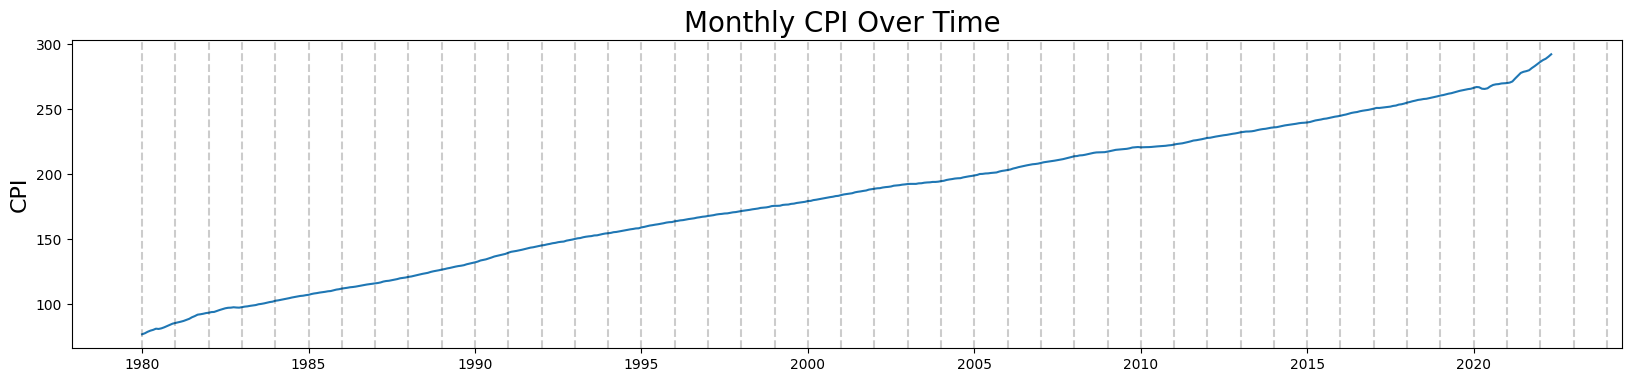

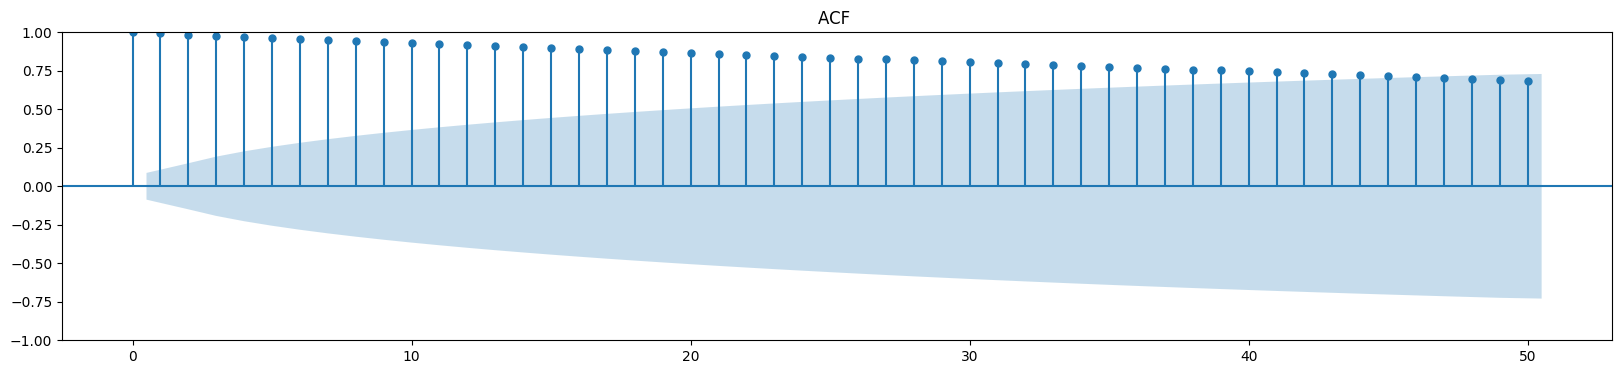

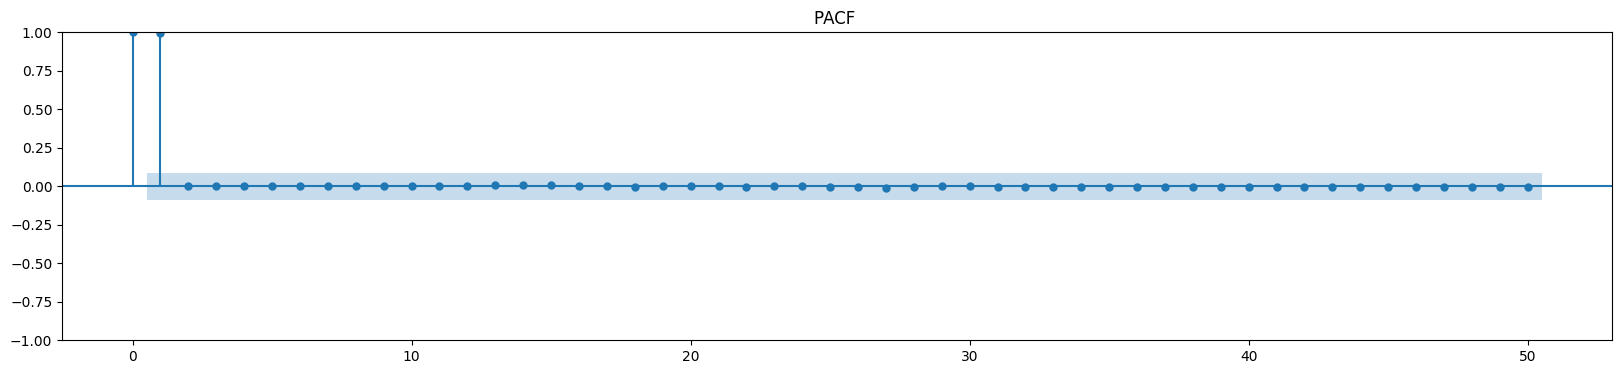

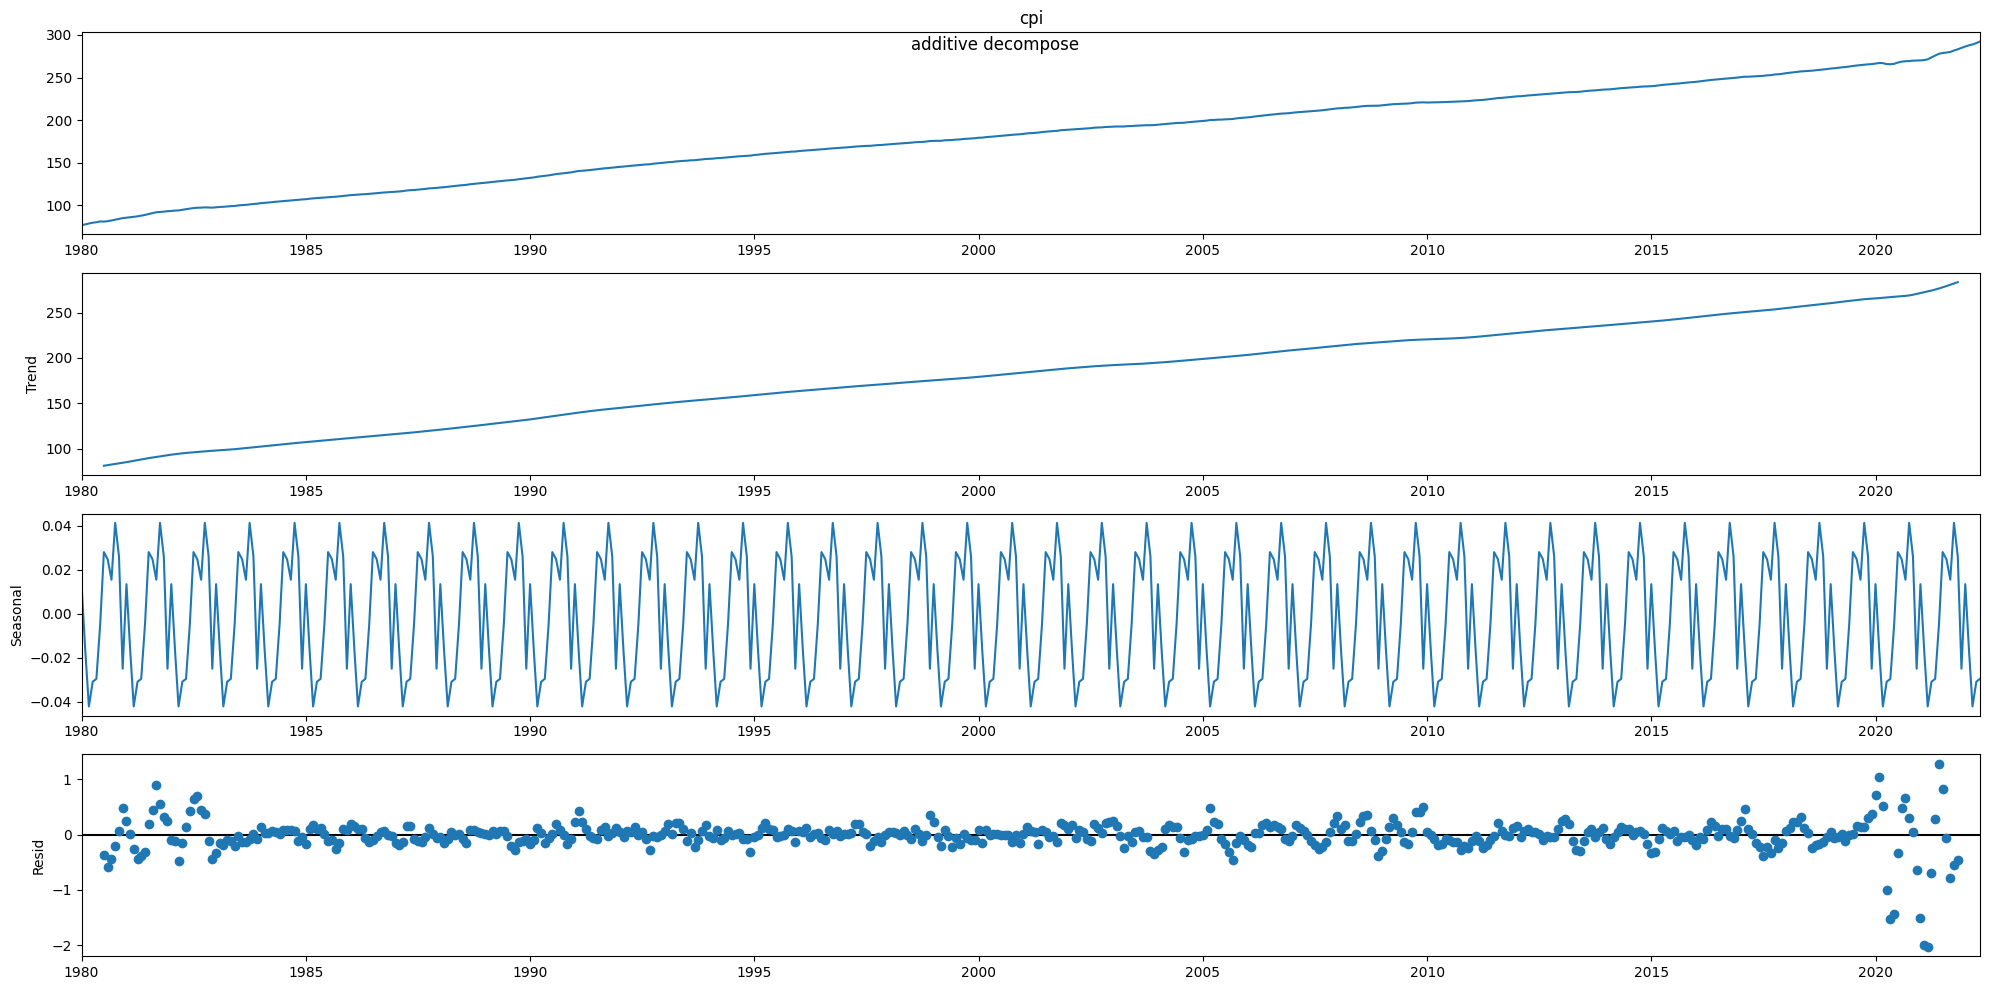

In [73]:
#https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.het_goldfeldquandt.html
plotAll(df_clean, column='cpi', plottitle='Monthly CPI Over Time', operator='', plotylabel='CPI', startyear=start_year, endyear=end_year+3, models='additive', periods=12, lag=50)

### Calculating all the possible Time Series data transformation

Please run this before running the below graph plotting

In [74]:
#All stationarity result after log and differencing
allStationarity(df_clean,'cpi')
df_log = df_clean[['after_log']]
df_log.rename(columns={"after_log": "cpi"}, inplace=True)

df_log_diff1_rseason = df_clean[['log_diff1_rseason']]
df_log_diff1_rseason.rename(columns={"log_diff1_rseason": "cpi"}, inplace=True)

cpi : non-stationary (p-value: 0.9980171572974418)
after_log : non-stationary (p-value: 0.8548462353135295)
difference_1 : non-stationary (p-value: 0.8602846503051826)
difference_2 : stationary (p-value: 1.1179257503746878e-12)
log_difference_1 : stationary (p-value: 0.0008252171094794517)
log_difference_2 : stationary (p-value: 2.5520275982574872e-27)
log_diff1_rseason : stationary (p-value: 4.057282031026334e-18)


In [75]:
df_train

,cpi
date,
1980-01-01,76.700
1980-02-01,77.500
1980-03-01,78.600
1980-04-01,79.500
1980-05-01,80.100
...,...
2022-01-01,286.431
2022-02-01,287.878
2022-03-01,288.811


### Anomaly Detection

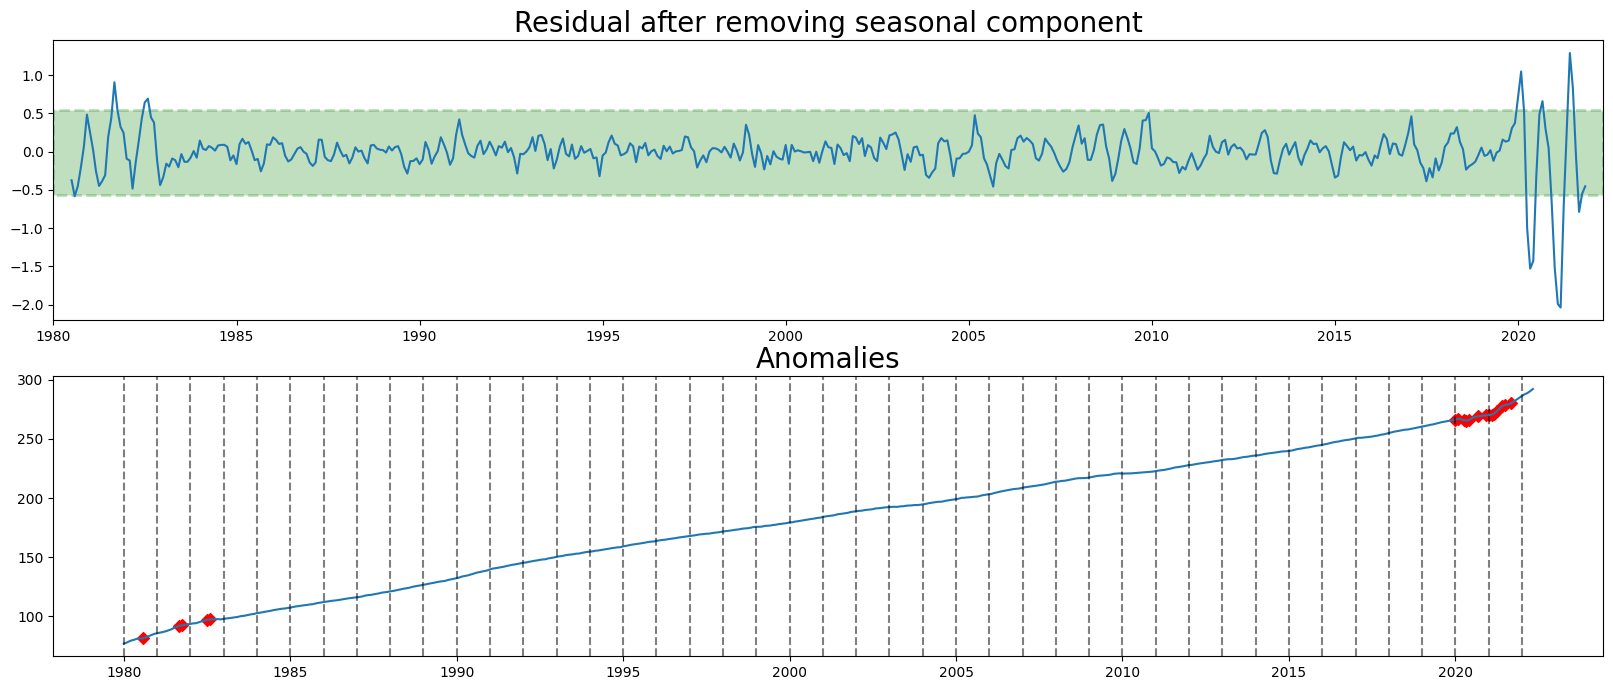

In [76]:
'''
1980 The Great Inflation
https://www.federalreservehistory.org/essays/great-inflation
2020 The COVID-19 pandemic
2021 Quantitative Easing effect ? 
'''
#['df_train','df_log','df_log_diff1_rseason']
anomalies = anomalyDetect(df_train, 'cpi', start=start_date, end=end_date, sd=2)
# anomalies.head()

### Graph ploting with stationartiy, seasonality check

ADF statistic: -10.268593287335847
p-value      : 4.057282031026334e-18
Critical values:
  1%,  -3.444162847239118
Critical values:
  5%,  -2.8676311169658177
Critical values:
  10%,  -2.5700143303792107
It is stationary (p-value: 4.057282031026334e-18)


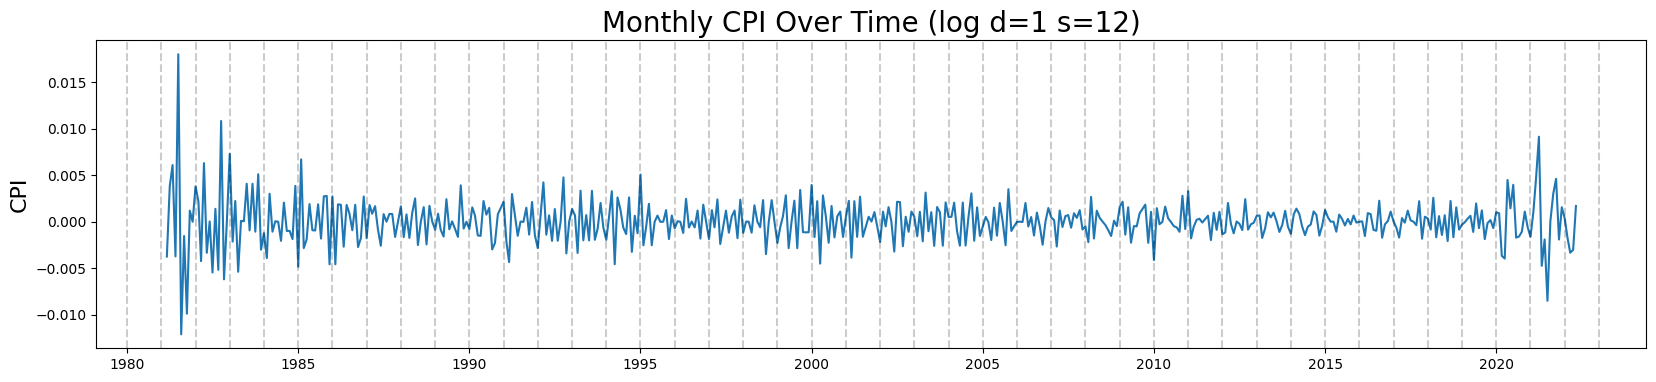

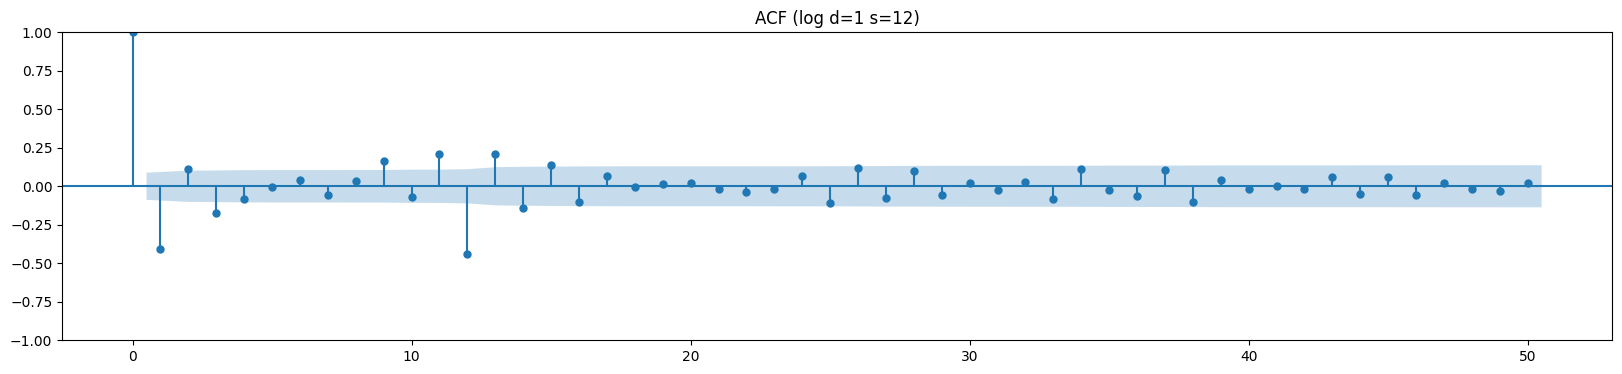

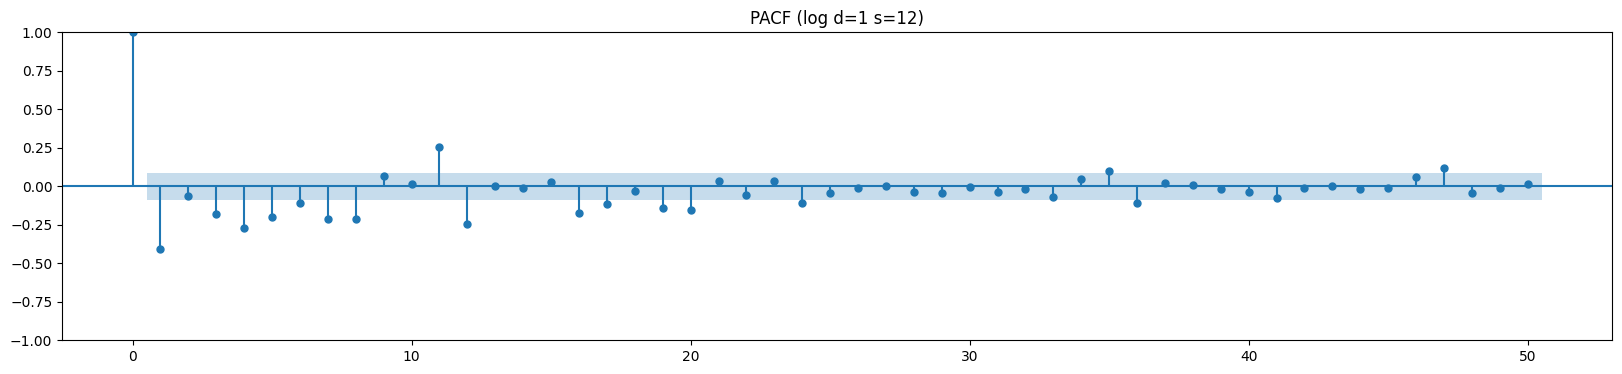

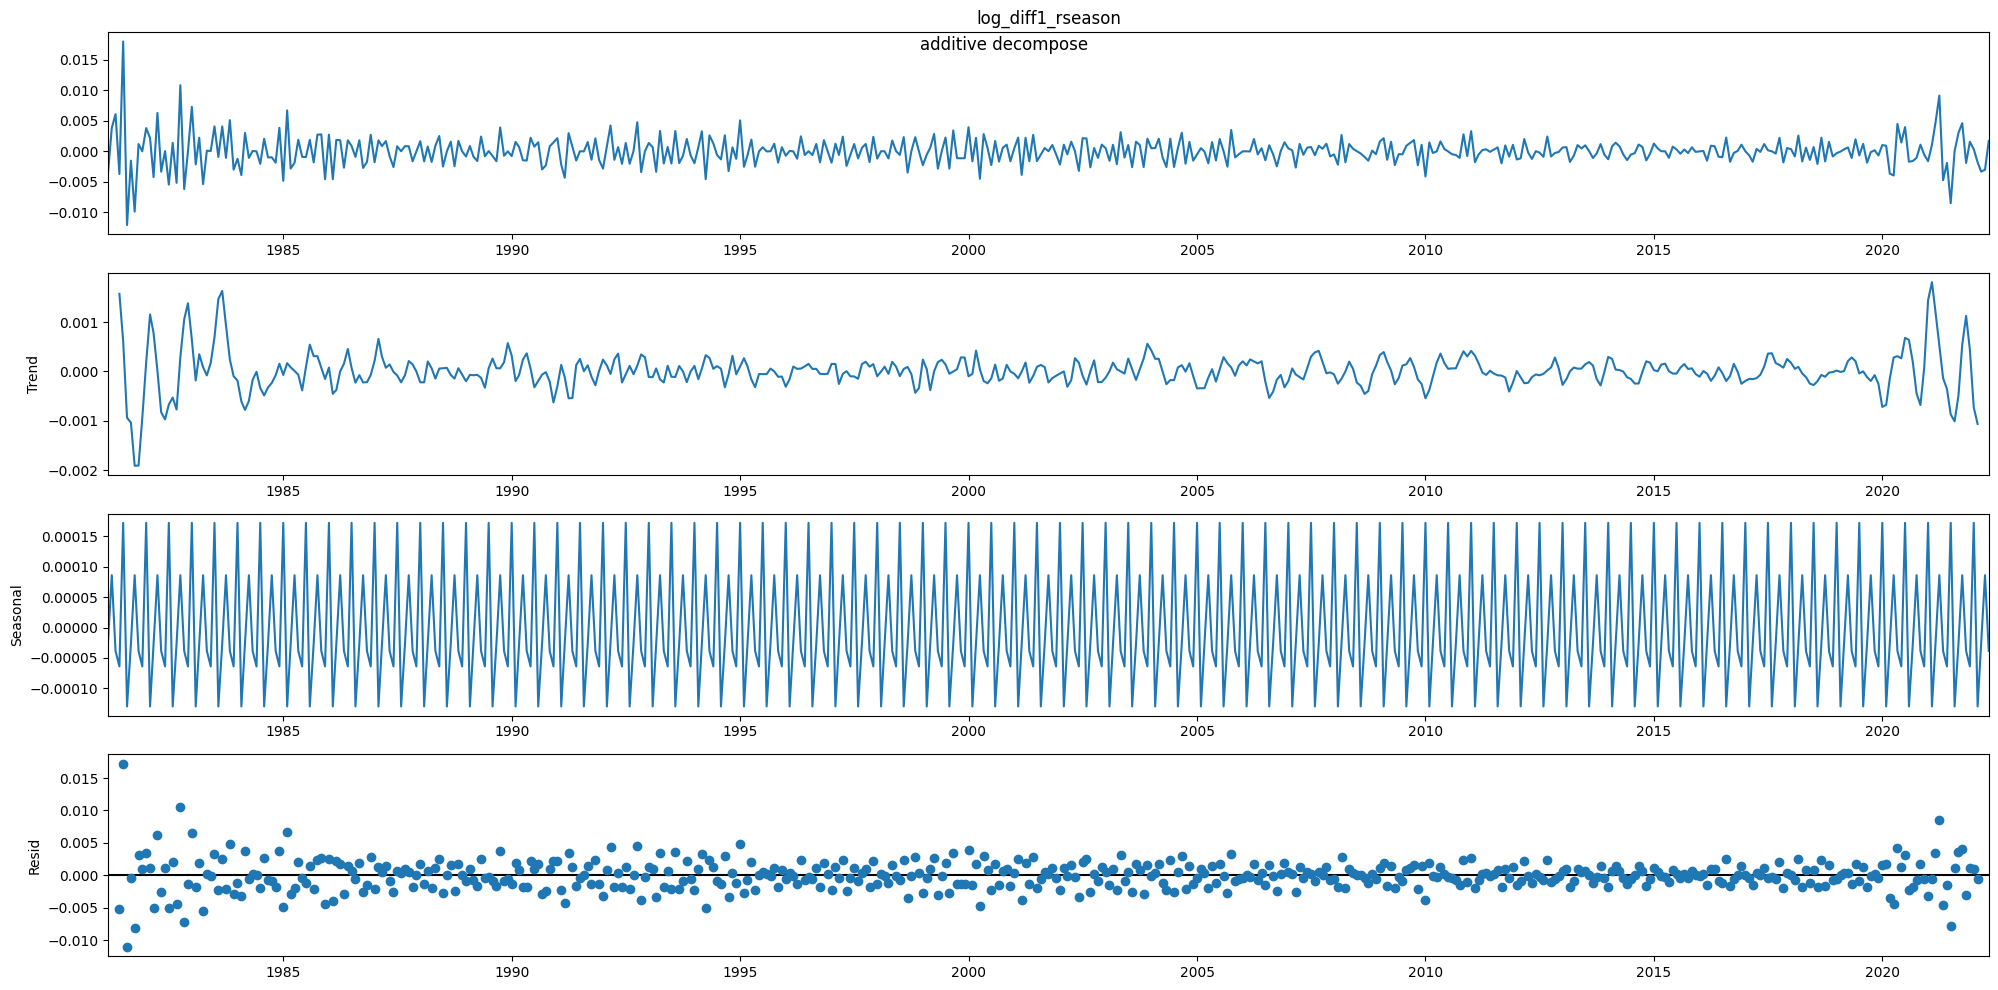

In [117]:
#Log Transformation
# ['after_log','difference_1','difference_2','log_difference_1','log_difference_2', 'log_diff1_rseason']
# plotAll(dataframe, column, plottitle, plotylabel, startyear, endyear, models='additive', periods=1) multiplicative
plotAll(df_clean, column='log_diff1_rseason', plottitle='Monthly CPI Over Time', operator='(log d=1 s=12)', plotylabel='CPI', startyear=start_year, endyear=end_year+2, models='additive', periods=6, lag=50)

### Model fitting, please fit a model according to the ACF and PACF plot

In [126]:
#https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMA.html#statsmodels-tsa-arima-model-arima
#https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMAResults.html#statsmodels-tsa-arima-model-arimaresults
#https://github.com/statsmodels/statsmodels/issues/6212
#Use df_log for logged data, use df_train for original data  | seasonal_order=(P,D,Q,s) if the seasonal cycles is same shape then (D = 0)
p,d,q = 0,1,5
P,D,Q,s = 0,1,1,12
model = ARIMA(df_log, order=(p,d,q), seasonal_order=(P,D,Q,s))
#Using Maximum likelihood estimation
model_fit = model.fit(method='innovations_mle')
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                cpi   No. Observations:                  495
Model:             ARIMA(0, 1, 5)x(0, 1, [1], 12)   Log Likelihood                2508.202
Date:                            Sat, 19 Nov 2022   AIC                          -5002.403
Time:                                    21:30:12   BIC                          -4973.158
Sample:                                03-01-1981   HQIC                         -4990.910
                                     - 05-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4451      0.031     14.181      0.000       0.384       0.507
ma.L2          0.4094      0.034   

### Residual Analysis
#### Ljung-Box test for model adequacy

In [131]:
'''
https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMAResults.test_serial_correlation.html
Ljung-Box test for serial correlation of standardized residuals (check the adequacy)
Null hypothesis is no serial correlation.
df_adjust: when true df = k-p-q
lags: default maxlag is min(10, number of observation//5), (lags is K)
'''
result = model_fit.test_serial_correlation(method='ljungbox',df_adjust=True, lags=11)
lgBoxResult(result)

At Lag: 0, Test statistic: 0.024832810272009224, p-value:nan
p-value > 0.05, Null hypothesis is not rejected, there is no serial correlation.
------------------------------------------------------------------------------------------
At Lag: 1, Test statistic: 0.46047631153240504, p-value:nan
p-value > 0.05, Null hypothesis is not rejected, there is no serial correlation.
------------------------------------------------------------------------------------------
At Lag: 2, Test statistic: 0.46086260859210154, p-value:nan
p-value > 0.05, Null hypothesis is not rejected, there is no serial correlation.
------------------------------------------------------------------------------------------
At Lag: 3, Test statistic: 0.48111946148018575, p-value:nan
p-value > 0.05, Null hypothesis is not rejected, there is no serial correlation.
------------------------------------------------------------------------------------------
At Lag: 4, Test statistic: 0.9109057445341094, p-value:nan
p-value > 0.

#### Standardized Residual: Sequence, Histogram, Q-Q plot, Correlogram, ACF, PACF

-------------------------------Shapiro-Wilk normality test Result------------------------------
Test statistic: 0.950112521648407
p-value       : 1.122745212772669e-11
p-value <= 0.05, Null hypothesis is rejected, data was NOT drawn from a normal distribution.
-----------------------------------------------------------------------------------------------
Figure(1000x1000)
Figure(1000x400)
Figure(1000x400)


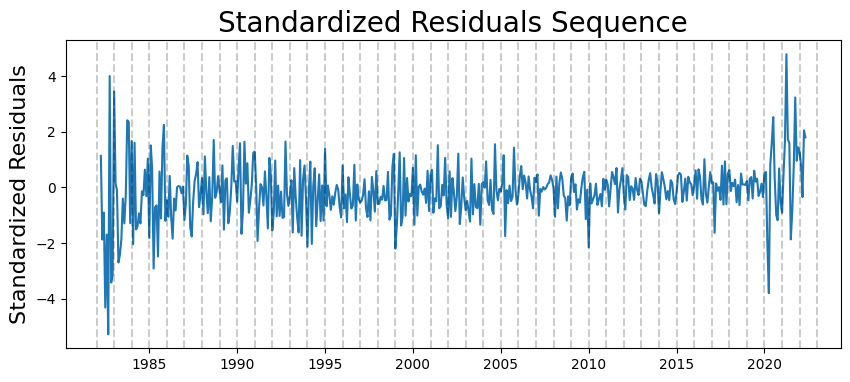

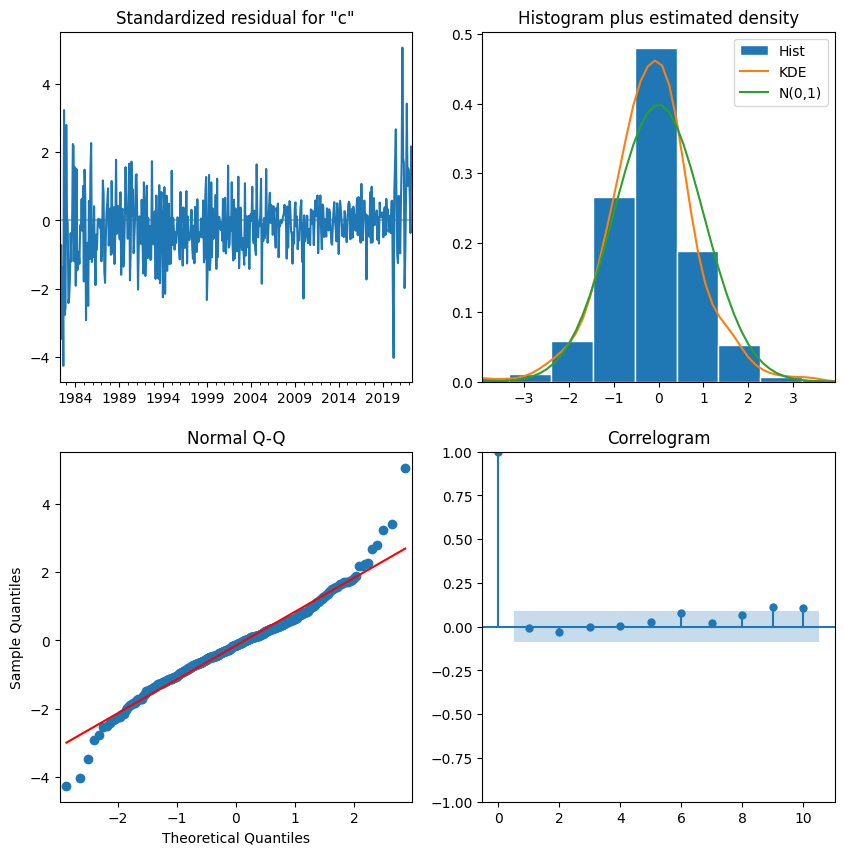

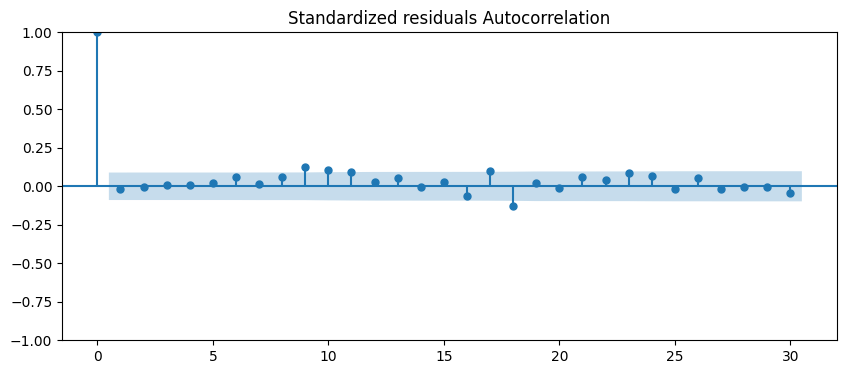

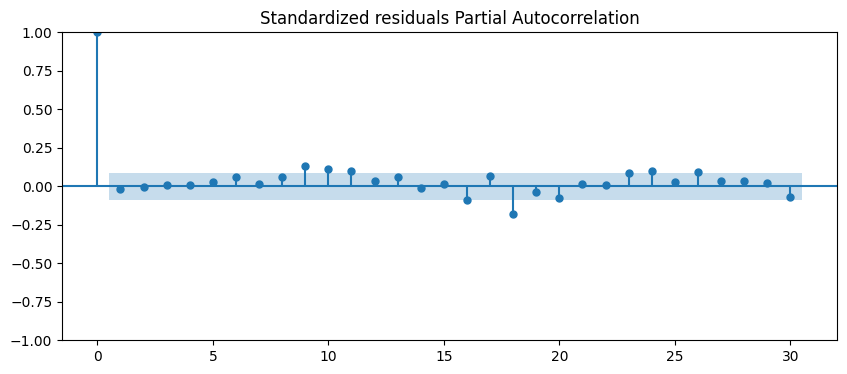

In [128]:
'''Test for normality of standardized residuals'''

#extract residuals sequence and calculate standardized residuals sequence
resid = model_fit.resid[model.loglikelihood_burn:]
std_resid = resid / resid.std()
plotStdResid(std_resid, start_year+2, end_year+2)

#Shapiro-Wilk normality test
#Null hypothesis: data was drawn from a normal distribution
shapiro_test(std_resid)

#Standardized residual sequence, Histogram, Q-Q plot, correlogram
print(model_fit.plot_diagnostics(figsize=(10,10)))

#ACF and PACF of the residuals
plt.rcParams.update({'figure.figsize':(10,4)})
print(plot_acf(std_resid,  alpha=.05, lags=30, title='Standardized residuals Autocorrelation'))
print(plot_pacf(std_resid,  alpha=.05, method='ywm',lags=30, title='Standardized residuals Partial Autocorrelation'))

In [81]:
'''
Overparameterized method to check the adequacy
'''


'\nOverparameterized method to check the adequacy\n'